# Strain mapping of simulated Ge/SiGe multilayer stacks

Colin Ophus - 2021 July 12

This notebook measures the strain fields of a simulated 4D-STEM dataset which consists of alternating Ge / Si50Ge50 multilayer stacks, on a Si25Ge75 substrate.  This notebook uses the "ideal" simulation, where the sample is aligned perfectly along the zone axis.  All of the non-uniformity of the diffracted disks is due to multiple scattering.

[Download the simulated Ge/SiGe multilayer dataset with an ideal structure.](https://drive.google.com/file/d/1EsbTlbbMZtIB9oZqEuo1jLwMU8o24soU/view?usp=sharing)

### Simulation Parameters

|Parameter | Value | Units |
|:--- |:--- |:--- |
| accelerating voltage | 200 | kV |
| wavelength | 0.02508 | Ang |
| convergence semiangle | 2 | mrads |
| cell dimensions | (1008.28,   253.58,  404.14) | Ang |
| algorithm | PRISM |  |
| interpolation factors | (12, 3) |  |
| scan range x | (0.1, 0.9) | Ang |
| scan range y | (0.1, 0.9) | Ang |
| probe step x | 4.03 | Ang |
| probe step y | 4.06 | Ang |

This tutorial was written for py4DSTEM version 0.12.3

# Data file paths, imports

In [1]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
py4DSTEM.__version__

'0.12.3'

In [3]:
# File paths - output files will be augmented with the correct file extension
file_path_input = '/media/cophus/DATA/4DSTEM/Ge_SiGe_multilayer_stack_ideal.h5'
file_path_output = '/media/cophus/DATA/4DSTEM/output_Ge_SiGe_multilayer_stack_ideal'
# file_path_input = 'C:/data/SiGe_sims/Ge_SiGe_multilayer_stack_ideal.h5'
# file_path_output = 'C:/data/SiGe_sims/output_Ge_SiGe_multilayer_stack_ideal'

In [4]:
py4DSTEM.io.read(file_path_input)

py4DSTEM file version 0.9.0
Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DataCube          (201, 50, 420, 422)     CBED_array_depth0000                                  
  1       DiffractionSlice  (420, 422)              probe                                                 
  2       RealSlice         (201, 50, 62)           virtual_detector_depth0000                            


In [5]:
# Import the vacuum probe and simulated 4D-STEM datacube
probe = py4DSTEM.io.read(file_path_input, data_id='probe');
dataset = py4DSTEM.io.read(file_path_input, data_id='CBED_array_depth0000');

# Simple visualizations

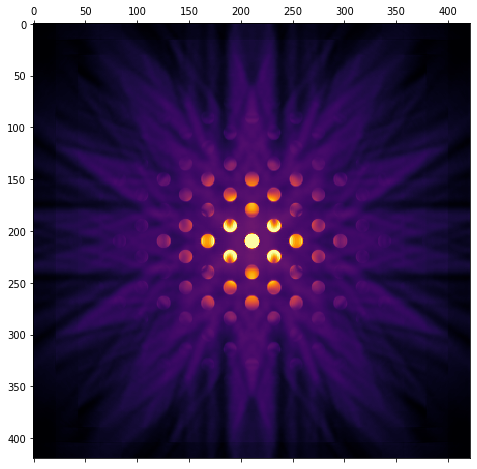

In [6]:
# Plot the mean CBED
diffraction_pattern_mean = np.mean(dataset.data, axis=(0,1))
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    clipvals='manual',
    min=0.0000002,
    max=0.0003,
    scaling='power',
    power=0.2,
    cmap='inferno')

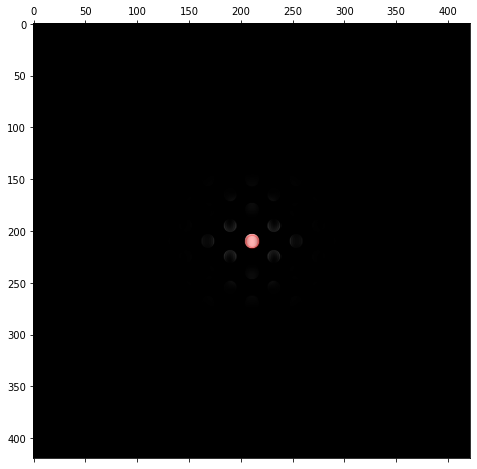

Estimated probe radius = 6.30 pixels


In [7]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(
    diffraction_pattern_mean)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    diffraction_pattern_mean, 
    (qx0, qy0), 
    probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

In [8]:
# Next, create a BF virtual detector using the the center beam position (qxy0, qy0), and a virtual DF detector.
# The DF virtual detector will be set to high scattering angles, picking up just a hint of the coherent diffraction.
expand_BF = 2.0
det_DF = (75,1000)

image_BF = py4DSTEM.process.virtualimage.get_virtualimage_circ(
    dataset, 
    qx0, qy0, 
    probe_semiangle + expand_BF)
image_DF = py4DSTEM.process.virtualimage.get_virtualimage_ann(
    dataset, 
    qx0, qy0, 
    det_DF[0],
    det_DF[1])

100%|███████████████████████████████████████████████████████████████████████████| 10050/10050 [00:01<00:00, 6025.20it/s]


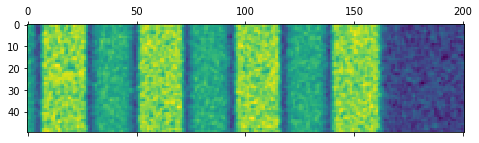

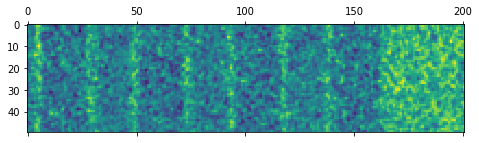

In [9]:
# Show the BF and DF images
py4DSTEM.visualize.show(
    np.transpose(image_BF),
    figsize=(16,2),
    cmap='viridis')
py4DSTEM.visualize.show(
    np.transpose(image_DF),
    figsize=(16,2),
    cmap='viridis')

# Bragg disk detection

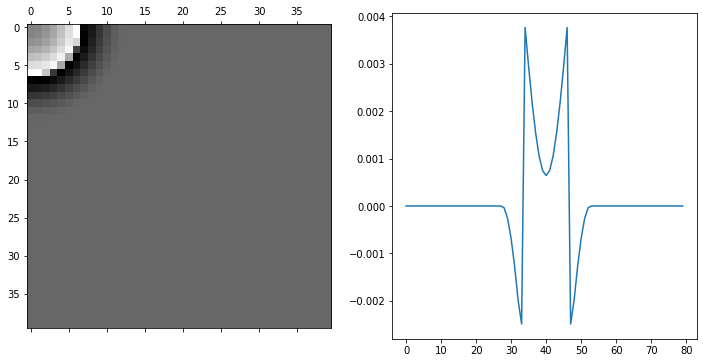

In [10]:
# Construct a probe template kernel - we will the simulated vacuum probe we loaded earlier.

# Shift probe to the origin and apply normalization by subtracting a sigmoid function.
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(
    probe.data, 
    probe_semiangle * 0.0,                                                        
    probe_semiangle * 2.0,)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=40, 
    L=40, 
    W=1)

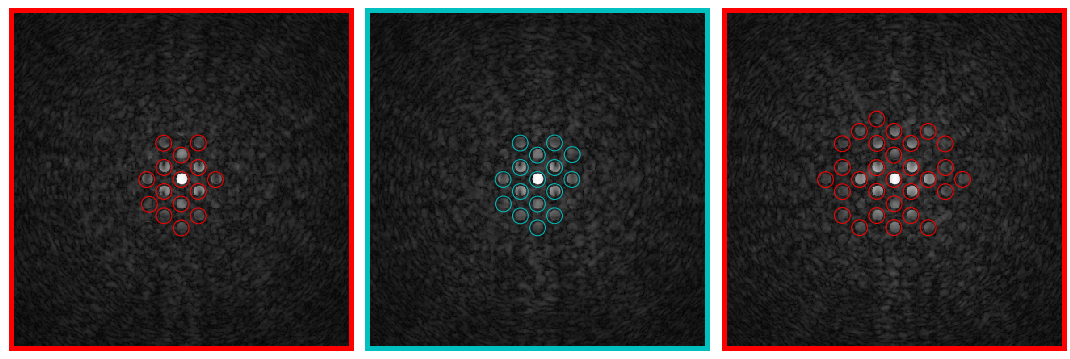

In [11]:
# Test hyperparameters on a few probe positions
rxs = 10,100,190
rys = 25,25,25
colors=['r','c','r','c','r','c']

dp0 = dataset.data[rxs[0],rys[0],:,:]
dp1 = dataset.data[rxs[1],rys[1],:,:]
dp2 = dataset.data[rxs[2],rys[2],:,:]

# Run the disk detection on the selected DPs
corrPower=0.9
sigma=0
edgeBoundary=100
minRelativeIntensity=0.0025
relativeToPeak=0
minPeakSpacing=20
maxNumPeaks=80
subpixel='poly'
upsample_factor=20

disks_selected = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(
    dataset,
    probe_kernel,
    rxs,
    rys,
    corrPower=corrPower,
    sigma=sigma,edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,
    upsample_factor=upsample_factor)

py4DSTEM.visualize.show_image_grid(
    lambda i:[dp0,dp1,dp2][i],H=1,W=3,
    axsize=(5,5),
    scaling='power',
    power=0.25,                  
    get_bordercolor=lambda i:colors[i],                    
    get_x=lambda i:disks_selected[i].data['qx'],
    get_y=lambda i:disks_selected[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    open_circles=True,scale=250)

In [12]:
# Find all Bragg peaks
# WARNING - this is the "slow" step, though it will only take ~8 minutes for a dataset of this size.
# Note the speed depends strongly on whether 'multicorr' (more accurate) or 'poly' (faster) is used.

bragg_peaks = py4DSTEM.process.diskdetection.find_Bragg_disks(
    datacube=dataset,
    probe=probe_kernel,                 
    corrPower=corrPower,                       
    sigma=sigma,                 
    edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,    
    upsample_factor=upsample_factor
)

Finding Bragg Disks: 100%|█████████████████████████████████████████████████████████| 10.1k/10.1k [07:05<00:00, 23.6DP/s]


# Fit crystal lattice

In [18]:
# Center the Bragg disk positions about the origin.
# Note that in some experimental datasets, we would need to correct for pattern shift.
# This is not necessary in a simulation (unless we include simulated pattern shift!).
bragg_peaks_centered = py4DSTEM.process.calibration.center_braggpeaks(
    bragg_peaks,
    qx0=qx0,
    qy0=qy0)

Computing Bragg vector map: 100%|███████████████████████████████████████████████████| 10.1k/10.1k [00:12<00:00, 833DP/s]


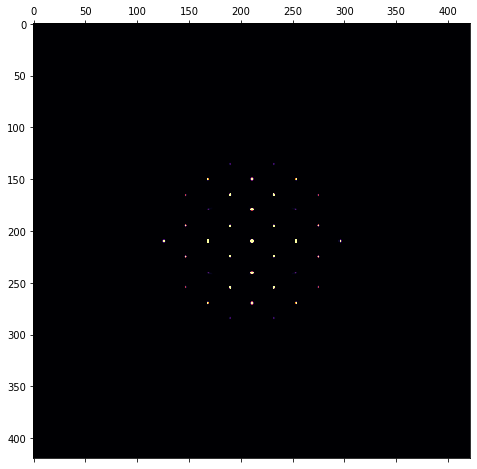

In [19]:
# Compute and plot Bragg vector map (BVM).
# This is a 2D histogram of all detected Bragg peaks.

# Compute the BVM
bragg_vector_map = py4DSTEM.process.diskdetection.get_bvm(
    bragg_peaks_centered,
    dataset.Q_Nx,
    dataset.Q_Ny)

# plot the BVM
py4DSTEM.visualize.show(
    bragg_vector_map,
    cmap='inferno',
    clipvals='manual',
    min=0,
    max=1e-2)

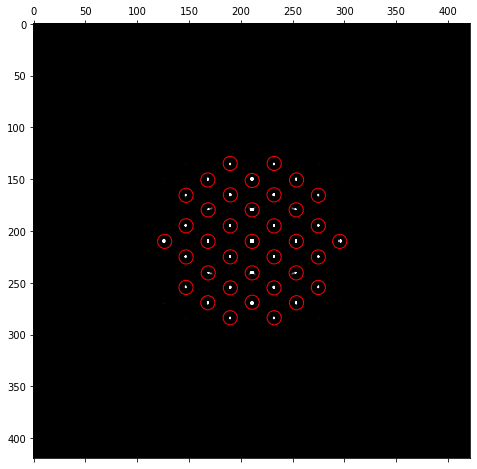

In [20]:
# Get all local maximum from the BVM, plot the candidate peaks
gx, gy, gI = py4DSTEM.process.utils.get_maxima_2D(
    bragg_vector_map,
    sigma=0, 
    edgeBoundary=10,
    minSpacing=20,
    minRelativeIntensity=0.0001,
    relativeToPeak=0,
    maxNumPeaks=100,
    subpixel='multicorr'
)

# Plot the candidate lattice coordinates
py4DSTEM.visualize.show_points(
    bragg_vector_map,
    x=gx,
    y=gy,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e-3,
    open_circles=True,
    scale=200)

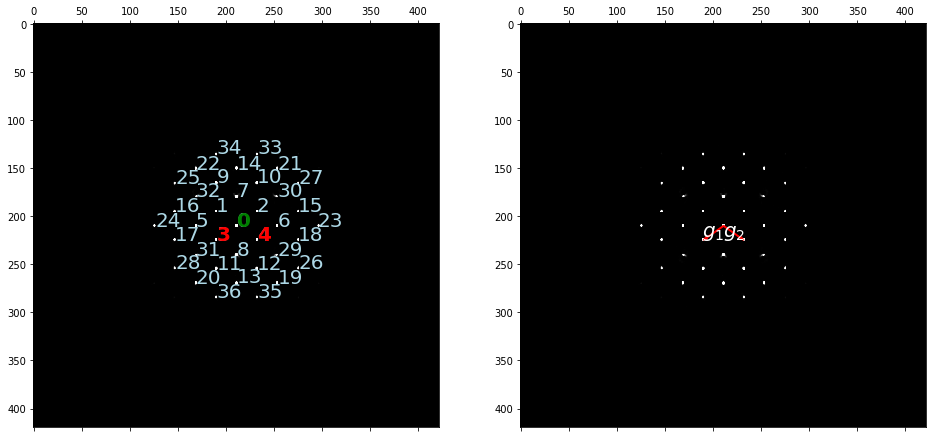

In [21]:
# Define peaks to use for computing strain maps
index_0, index_g1, index_g2 = 0, 3, 4

# Plot the selected lattice vectors - note they are in order of detected intensity
g1,g2 = py4DSTEM.visualize.select_lattice_vectors(
    bragg_vector_map,    
    figsize=(16,8),
    clipvals='manual',
    min=0,
    max=1e-3,
    gx=gx,gy=gy,
    i0=index_0,
    i1=index_g1,
    i2=index_g2)

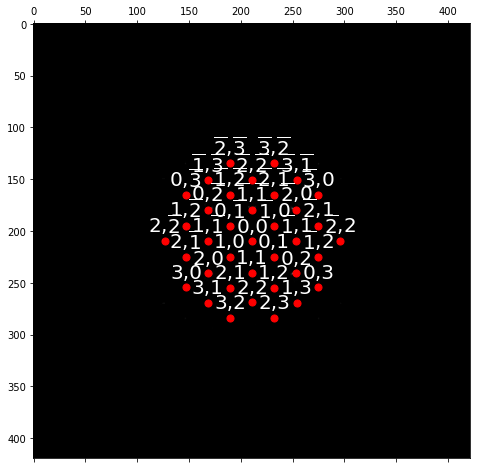

In [22]:
# Get indexing for all peaks, plot the indices overlaid onto the peaks
h, k, braggdirections = py4DSTEM.process.latticevectors.index_bragg_directions(
    qx0,qy0,
    gx,gy,
    g1,g2)
py4DSTEM.visualize.show_bragg_indexing(
    bragg_vector_map,
    clipvals='manual',
    min=0,
    max=1e-3,
    braggdirections=braggdirections,
    points=True)

In [23]:
# maximum peak spacing from expected positions
max_peak_spacing = 8

# Add indices to the bragg_peaks PointListArray
bragg_peaks_indexed = py4DSTEM.process.latticevectors.add_indices_to_braggpeaks(
    bragg_peaks_centered,
    braggdirections,
    maxPeakSpacing=max_peak_spacing,
    qx_shift=qx0,
    qy_shift=qy0)

In [24]:
# Fit the lattice in all diffraction images
g1g2_map = py4DSTEM.process.latticevectors.fit_lattice_vectors_all_DPs(bragg_peaks_indexed)

100%|███████████████████████████████████████████████████████████████████████████| 10050/10050 [00:01<00:00, 7106.70it/s]


In [25]:
g1g2_map.data.shape

(201, 50, 8)

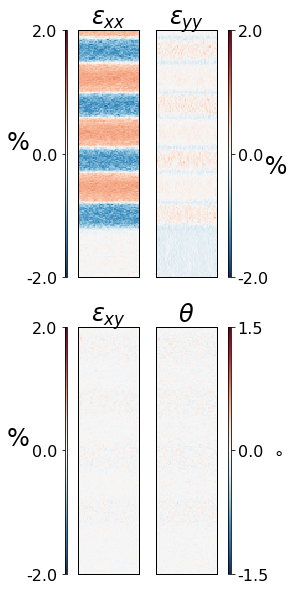

In [26]:
# Compute thae strain using the median of the measured g1g2 as reference
strainmap_mediang1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_region(
    g1g2_map,
    mask=np.ones((dataset.R_Nx,dataset.R_Ny),dtype=bool))

# Rotate the lattice direction of the strain map 
# (pattern is rotated with respect to the scan direction)
g_reference = np.add(g2, g1)
strainmap = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_mediang1g2,
    g_reference[0],
    g_reference[1])

# plot the 4 components of the strain tensor
py4DSTEM.visualize.show_strain(
    strainmap,
    vrange_exx=[-2.0, 2.0],
    vrange_theta=[-1.5, 1.5],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(3,10))

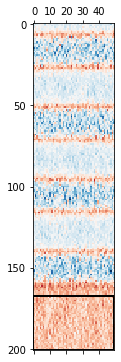

In [27]:
# Set the reference lattice to be the probe positions inside the substrate.

x0,xf = 168,201
y0,yf = 0,50

py4DSTEM.visualize.show(
    strainmap_mediang1g2.slices['e_yy'],              
    mask=strainmap_mediang1g2.slices['mask'],
    figsize=(2, 6),
    cmap='RdBu',
    clipvals='centered',
    min=0,
    rectangle={'lims':(x0,xf,y0,yf),'fill':False,'color':'k'})

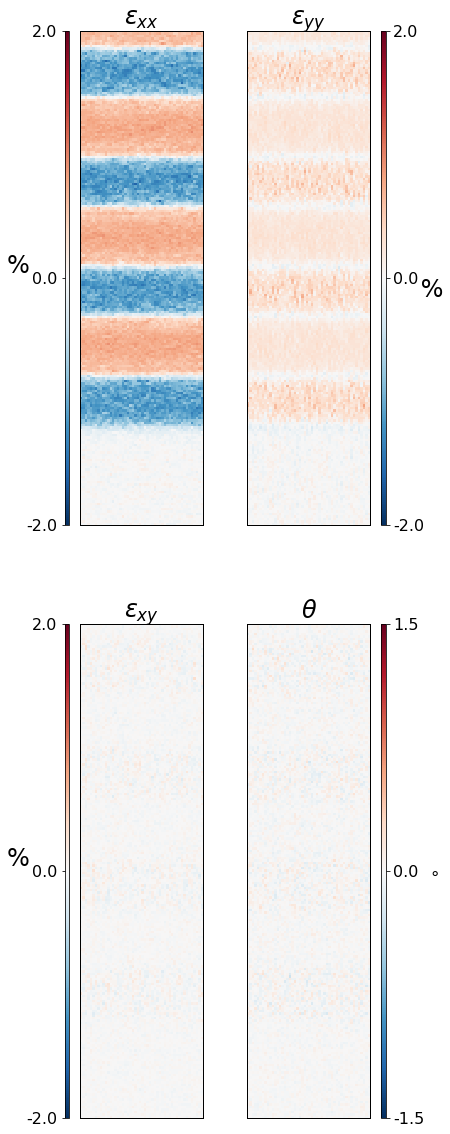

In [28]:
# Get new reference lattice vectors
mask = np.zeros((dataset.R_Nx,dataset.R_Ny),dtype=bool)
mask[x0:xf,y0:yf] = True
g1_ref,g2_ref = py4DSTEM.process.latticevectors.get_reference_g1g2(g1g2_map, mask)

# Recalculate the strain maps using the new reference lattice
strainmap_ROI_g1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_g1g2(
    g1g2_map,
    g1_ref,
    g2_ref)

# Rotate the lattice direction of the strain map 
strainmap_ROI = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_ROI_g1g2,
    g_reference[0],
    g_reference[1])

# plot the 4 components of the strain tensor
fig,axs = py4DSTEM.visualize.show_strain(
    strainmap_ROI,
    vrange_exx=[-2.0, 2.0],
    vrange_theta=[-1.5, 1.5],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(6,20),
    returnfig=True)

# Plot line traces for the mean strain values

In [29]:
# # Browse Prismatic format HDF5
# def print_attrs(name, obj):
#     print(name)
#     for key, val in obj.attrs.items():
#         print('%s %s' % (key, val))

# f = h5py.File(file_path_input,'r')
# f.visititems(print_attrs)

In [30]:
# Get probe positions along the vertical direction
# probe_step_x = py4DSTEM.io.DataCube(data=f['Experiments/-fpd_expt-fpd_data/data'][...])
# probe_step_x = f['4DSTEM_simulation']['data']['datacubes']['CBED_array_depth0000']['dim1'][...]
probe_step_x = np.arange(0,strainmap_ROI.data.shape[0]) * 4.033104 + 100.82759

In [31]:
probe_step_x[1]-probe_step_x[0]

4.0331039999999945

In [32]:
probe_step_x[0]

100.82759

(-0.02, 0.02)

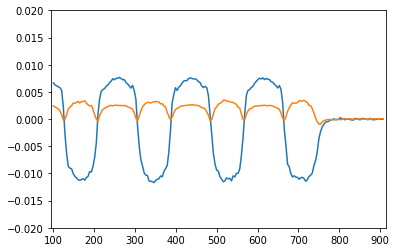

In [33]:
# Get mean E_xx and E_yy strain maps along the perpendicular to growth direction
strain_mean_e_xx = np.mean(strainmap_ROI.slices['e_xx'],axis=1)
strain_mean_e_yy = np.mean(strainmap_ROI.slices['e_yy'],axis=1)

# Plot line traces
plt.plot(probe_step_x, strain_mean_e_xx)
plt.plot(probe_step_x, strain_mean_e_yy)
plt.xlim(95,914)
plt.ylim(-0.02, 0.02)

# Save data and strain maps

In [30]:
# Strain map figure
fig.savefig(file_path_output + '.pdf')

In [72]:
# Save all data in py4DSTEM format
# The diffraction space arrays we will save are:
file_path_output_h5 =  file_path_output + '.h5'
diff = py4DSTEM.io.DiffractionSlice(
    data=np.dstack([diffraction_pattern_mean, 
                    probe.data,
                    probe_kernel]),    
    slicelabels=['image_mean',
                 'probe',
                 'probe_kernel'],
    name='diffraction_images')

# The real space arrays we will save are:
real = py4DSTEM.io.RealSlice(
    data=np.dstack([image_BF, 
                    image_DF]),    
    slicelabels=['bright_field',
                 'dark_field'],
    name='real_space_images')

# Note we will also save the strain maps, but these are already stored as RealSlice objects.
# We will also store the center coordinates, estimated radius in pixels, strain reference direction,
# but most importantly - the Bragg disk positions and intensities (bragg_peaks_centered).
probe_fields = [("probe_semiangle",float),
              ("qx0", float),
              ("qy0", float)]
probe_data = py4DSTEM.io.PointList(coordinates=probe_fields)
probe_data.add_point((probe_semiangle, qx0, qy0))
probe_data.name = 'probe_data'

# Save all of the resulting data into a single .h5 file:
py4DSTEM.io.save(file_path_output_h5,
                 [diff,
                  real,
                  probe_data,
                  strainmap_ROI,                  
                  bragg_peaks_centered],
                 overwrite=True)

NameError: name 'strainmap_ROI' is not defined

In [73]:
# Check the results of the h5 file we just created
py4DSTEM.io.read(file_path_output_h5)

AssertionError: Error: specified filepath does not exist.